# 04 - Lectura y Postproceso de salidas WRF

En este capítulo se verá cómo realizar análisis avanzados de las salidas del modelo WRF usando Python. Partimos de datos NetCDF (wrfout) para extraer variables relevantes, recortar zonas, hacer cálculos derivados, perfiles verticales, estadísticas, y mapas complejos.

## Cargar el archivo WRF (netCDF) local

In [ ]:
url = "https://github.com/jpantojac/wrf-course/raw/refs/heads/main/data/wrfout_d01_2025-11-12_17-00-00"

!wget -O wrfout_d01_2025-11-12_17-00-00.nc $url
!pip install xarray
!pip install netCDF4


import xarray as xr
ds = xr.open_dataset('/content/wrfout_d01_2025-11-12_17-00-00.nc', engine='h5netcdf')

In [ ]:
import xarray as xr

# Cambiar por la ruta local de su archivo wrfout
#ruta_wrf = "../data/wrfout_d01_2025-11-12_17-00-00"
#ds = xr.open_dataset(ruta_wrf)

print(ds)


<xarray.Dataset> Size: 231MB
Dimensions:    (Time: 1, south_north: 325, west_east: 299, bottom_top_stag: 42,
                bottom_top: 41, west_east_stag: 300, south_north_stag: 326)
Coordinates:
    XLAT       (Time, south_north, west_east) float32 389kB ...
    XLONG      (Time, south_north, west_east) float32 389kB ...
    XTIME      (Time) datetime64[ns] 8B ...
    XLAT_U     (Time, south_north, west_east_stag) float32 390kB ...
    XLONG_U    (Time, south_north, west_east_stag) float32 390kB ...
    XLAT_V     (Time, south_north_stag, west_east) float32 390kB ...
    XLONG_V    (Time, south_north_stag, west_east) float32 390kB ...
Dimensions without coordinates: Time, south_north, west_east, bottom_top_stag,
                                bottom_top, west_east_stag, south_north_stag
Data variables: (12/26)
    Times      (Time) |S19 19B ...
    HGT        (Time, south_north, west_east) float32 389kB ...
    PH         (Time, bottom_top_stag, south_north, west_east) float32 16MB

## Exploración rápida de la estructura

In [3]:
# Listar variables disponibles
print("Variables en el dataset:")
print(ds.data_vars)

# Ver dimensiones principales
print("Dimensiones:")
print(ds.dims)

# Ver coordenadas
print("Coordenadas:")
print(ds.coords)

# Extraer atributos de la variable temperatura a 2m
print("Atributos de T2:")
print(ds['T2'].attrs)


Variables en el dataset:
Data variables:
    Times      (Time) |S19 19B ...
    HGT        (Time, south_north, west_east) float32 389kB ...
    PH         (Time, bottom_top_stag, south_north, west_east) float32 16MB ...
    PHB        (Time, bottom_top_stag, south_north, west_east) float32 16MB ...
    P          (Time, bottom_top, south_north, west_east) float32 16MB ...
    PB         (Time, bottom_top, south_north, west_east) float32 16MB ...
    PSFC       (Time, south_north, west_east) float32 389kB ...
    T          (Time, bottom_top, south_north, west_east) float32 16MB ...
    T2         (Time, south_north, west_east) float32 389kB ...
    T00        (Time) float32 4B ...
    TSK        (Time, south_north, west_east) float32 389kB ...
    Q2         (Time, south_north, west_east) float32 389kB ...
    QVAPOR     (Time, bottom_top, south_north, west_east) float32 16MB ...
    CLDFRA     (Time, bottom_top, south_north, west_east) float32 16MB ...
    QCLOUD     (Time, bottom_top

## Documentacion Oficial WRF

[Acceso a la Documentación](https://www2.mmm.ucar.edu/wrf/users/wrf_users_guide/build/html/output_variables.html)


## Extracción y conversión de variables

In [4]:
# Variables de interés, seleccionar primer tiempo
T2 = ds['T2'].isel(Time=0) - 273.15   # de Kelvin a Celsius

# Coordenadas para gráficas
lons = ds['XLONG'].isel(Time=0)
lats = ds['XLAT'].isel(Time=0)


## Graficar mapa de temperatura superficial

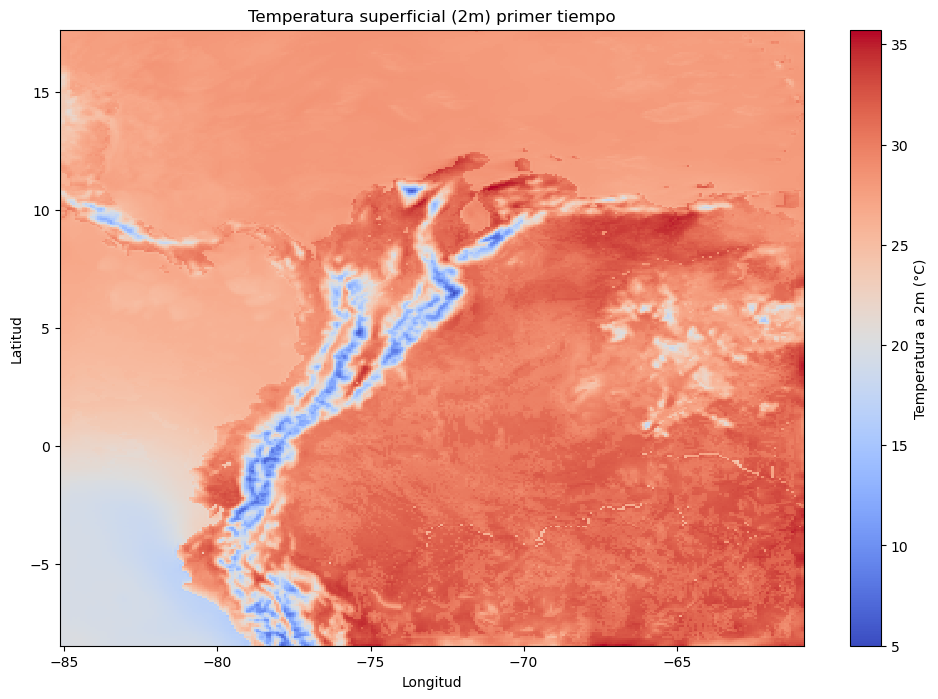

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
pcm = plt.pcolormesh(lons, lats, T2, cmap="coolwarm")
plt.colorbar(pcm, label="Temperatura a 2m (°C)")
plt.title("Temperatura superficial (2m) primer tiempo")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.show()


## Extracción de perfil vertical en punto específico

In [10]:
print(ds['T'].attrs)


{'FieldType': np.int32(104), 'MemoryOrder': 'XYZ', 'description': 'perturbation potential temperature theta-t0', 'units': 'K', 'stagger': ''}


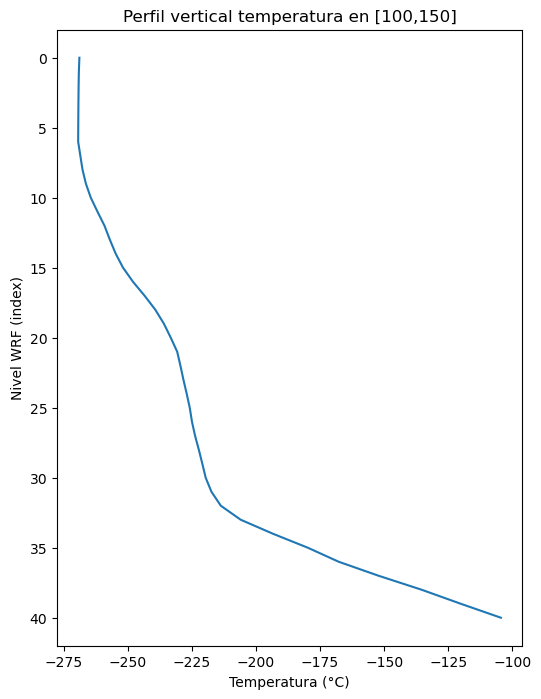

In [25]:
i, j = 150, 100  # índice espacial ejemplo (modificar)

# Variable temperatura nivel vertical T (Kelvin)
temp_vert = ds['T'].isel(Time=0, south_north=j, west_east=i) - 273.15

# Niveles atmosféricos WRF
niveles = ds['bottom_top'].values

plt.figure(figsize=(6,8))
plt.plot(temp_vert, niveles)
plt.gca().invert_yaxis()
plt.title(f"Perfil vertical temperatura en [{j},{i}]")
plt.xlabel("Temperatura (°C)")
plt.ylabel("Nivel WRF (index)")
plt.show()


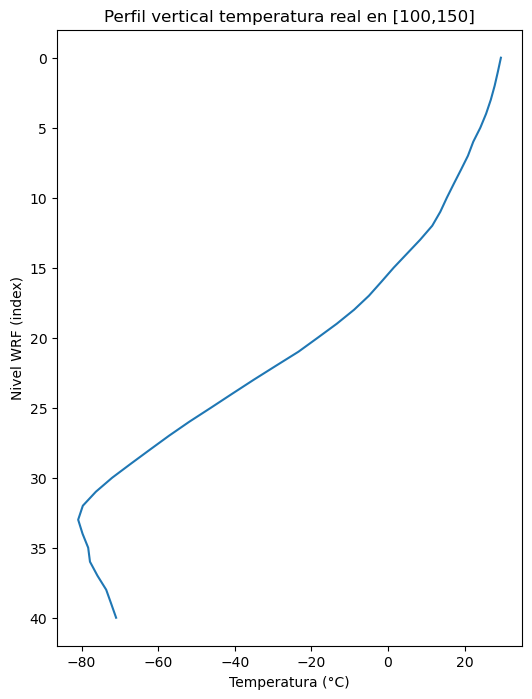

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Selecciona el punto para el perfil (usando índice o ubícalo vía lat/lon)
i, j = 150, 100  # índices como ejemplo

# 2. Extrae las variables necesarias en ese punto
T_pert = ds['T'].isel(Time=0, south_north=j, west_east=i)        # potencial perturbada [K]
P = ds['P'].isel(Time=0, south_north=j, west_east=i)             # presión perturbada [Pa]
PB = ds['PB'].isel(Time=0, south_north=j, west_east=i)           # presión base [Pa]
P_total = P + PB                                                 # presión total [Pa]

# 3. Calcula la temperatura potencial total (Theta)
theta = T_pert + 300                                             # [K]

# 4. Calcula la temperatura física usando relación de Poisson
P0 = 100000.0                                                    # presión de referencia [Pa]
kappa = 0.2854                                                   # R/Cp para aire seco
T_real = theta * (P_total / P0) ** kappa                         # temperatura real [K]
T_real_C = T_real - 273.15                                       # temperatura real en °C

# 5. Obtener niveles para eje Y
niveles = ds['bottom_top'].values

# 6. Plot del perfil vertical de temperatura real
plt.figure(figsize=(6,8))
plt.plot(T_real_C, niveles)
plt.gca().invert_yaxis()  # Para que el nivel 0 (superficie) esté arriba
plt.title(f"Perfil vertical temperatura real en [{j},{i}]")
plt.xlabel("Temperatura (°C)")
plt.ylabel("Nivel WRF (index)")
plt.show()


In [14]:
T_pert = ds['T'].isel(Time=0, south_north=j, west_east=i)
P = ds['P'].isel(Time=0, south_north=j, west_east=i)
PB = ds['PB'].isel(Time=0, south_north=j, west_east=i)
P_total = P + PB

theta = T_pert + 300
P0 = 100000.0
kappa = 0.2854

T_real = theta * (P_total / P0) ** kappa
T_real_C = T_real - 273.15


## Mejorar el Plot

Índice espacial encontrado: j=162, i=135 (lat=4.70, lon=-74.14)


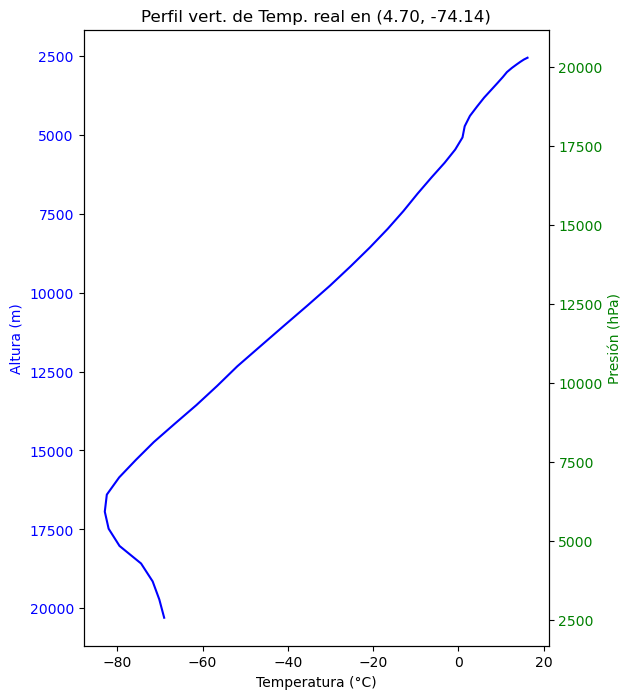

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Paso 1: Definir la ubicación en coordenadas geográficas donde quieres el perfil
lat_pt = 4.7    # Latitud (ejemplo: Bogotá)
lon_pt = -74.1  # Longitud

# Paso 2: Extraer los arrays de latitud y longitud del NetCDF (para el primer tiempo)
lats = ds['XLAT'].isel(Time=0)
lons = ds['XLONG'].isel(Time=0)

# Paso 3: Encontrar el índice (j,i) más cercano a lat_pt y lon_pt
# Usamos la distancia euclidiana "cuadrada" en espacio 2D. Potencia 2 es parte de la fórmula de Pitágoras:
# dist^2 = (lat_i - lat_pt)^2 + (lon_i - lon_pt)^2
# Así identificamos el punto de la grilla más cercano a la ubicación deseada.
dist = (lats - lat_pt)**2 + (lons - lon_pt)**2
j, i = np.unravel_index(dist.argmin(), dist.shape)

print(f"Índice espacial encontrado: j={j}, i={i} (lat={lats[j,i].values:.2f}, lon={lons[j,i].values:.2f})")

# Paso 4: Extraer las variables verticales para ese punto de la grilla
P     = ds['P'].isel(Time=0, south_north=j, west_east=i)      # presión perturbada (Pa)
PB    = ds['PB'].isel(Time=0, south_north=j, west_east=i)     # presión base (Pa)
T_pert= ds['T'].isel(Time=0, south_north=j, west_east=i)      # temperatura potencial perturbada (K)
PH    = ds['PH'].isel(Time=0, south_north=j, west_east=i)     # geopotencial perturbada
PHB   = ds['PHB'].isel(Time=0, south_north=j, west_east=i)    # geopotencial base

# Paso 5: Calcular la presión total (Pa) y la temperatura potencial total (K)
P_total = P + PB
theta = T_pert + 300

# Paso 6: Convertir la temperatura potencial en temperatura física real [K] y luego a °C
P0 = 100000.0
kappa = 0.2854
T_real = theta * (P_total / P0) ** kappa           # Temperatura física real [K]
T_real_C = T_real - 273.15                         # A °C

# Paso 7: Calcular la altura en metros usando el geopotencial total y la gravedad
# PH y PHB están en los niveles "stag"; sumamos y convertimos a metros: z = geopotencial / g
PH_full = PH + PHB
g = 9.81
height = PH_full / g       # Altura de interfaces de capa (m)
z = 0.5 * (height[:-1] + height[1:])  # Altura de cada centro de capa

# Paso 8: Calcular la presión en cada nivel en hPa y altura en pies
P_hPa = P_total / 100.0
z_ft = z * 3.28084

# Paso 9: Elegir el eje vertical (met, hPa o pies) para graficar el perfil vertical
fig, ax1 = plt.subplots(figsize=(6,8))

# Perfil vs altura en metros
ax1.plot(T_real_C, z, color="b")
ax1.set_xlabel("Temperatura (°C)")
ax1.set_ylabel("Altura (m)", color="b")
ax1.tick_params(axis='y', labelcolor='b')
ax1.invert_yaxis()   # Altura decreciente hacia arriba (superficie arriba)

# Eje secundario de presión en hPa
ax2 = ax1.twinx()
ax2.plot(T_real_C, P_hPa, color="g", alpha=0)  # No muestra línea, solo activa el eje
ax2.set_ylabel('Presión (hPa)', color="g")
ax2.set_ylim(ax1.get_ylim()[::-1])  # Sincroniza dirección
ax2.tick_params(axis='y', labelcolor='g')

# (Opcional) Eje secundario para altura en pies
# ax3 = ax1.secondary_yaxis('right', functions=(lambda m: m * 3.28084, lambda ft: ft / 3.28084))
# ax3.set_ylabel('Altura (ft)')

plt.title(f"Perfil vert. de Temp. real en ({lats[j,i].values:.2f}, {lons[j,i].values:.2f})")
plt.show()


Punto más cercano: j=162, i=135 (lat=4.70, lon=-74.14)


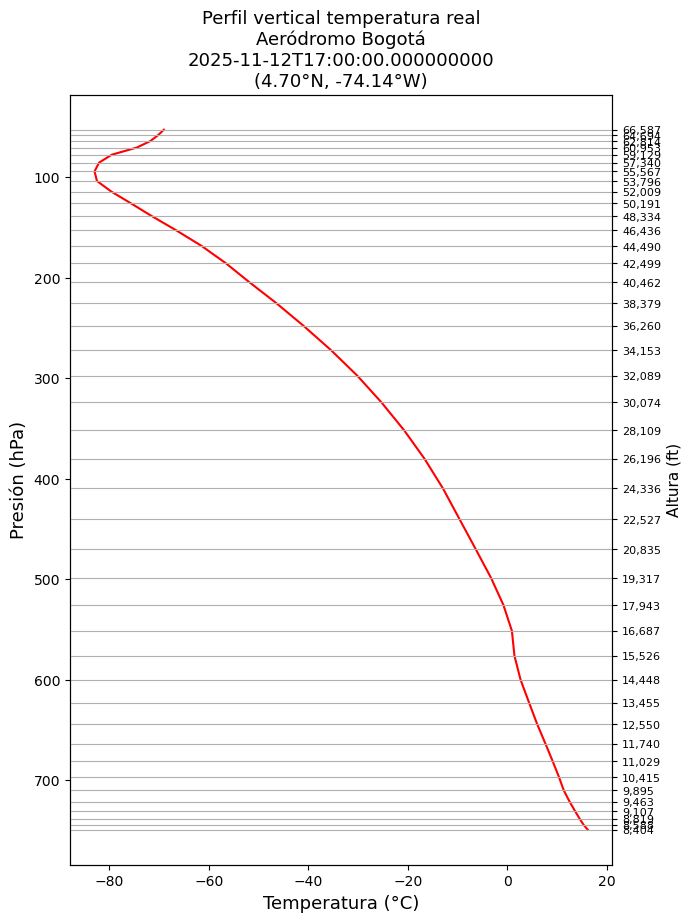

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# --- SELECCIÓN DEL PUNTO GEOGRÁFICO ---
lat_pt = 4.7
lon_pt = -74.1

lats = ds['XLAT'].isel(Time=0)
lons = ds['XLONG'].isel(Time=0)
fecha_hora = ds['XTIME'].isel(Time=0).values

dist = (lats - lat_pt)**2 + (lons - lon_pt)**2
j, i = np.unravel_index(dist.argmin(), dist.shape)
print(f"Punto más cercano: j={j}, i={i} (lat={lats[j,i].values:.2f}, lon={lons[j,i].values:.2f})")

# --- VARIABLES VERTICALES ---
P = ds['P'].isel(Time=0, south_north=j, west_east=i)
PB = ds['PB'].isel(Time=0, south_north=j, west_east=i)
T_pert = ds['T'].isel(Time=0, south_north=j, west_east=i)
PH = ds['PH'].isel(Time=0, south_north=j, west_east=i)
PHB = ds['PHB'].isel(Time=0, south_north=j, west_east=i)

# --- CÁLCULOS FÍSICOS EN CADA NIVEL ---
P_total = P + PB            # Presión total [Pa]
theta = T_pert + 300        # Temperatura potencial [K]
T_real = theta * (P_total / 100000.0) ** 0.2854
T_real_C = T_real - 273.15

PH_full = PH + PHB          # Geopotencial total
g = 9.81
height = PH_full / g        # Alturas en interfaces [m]
z_m = 0.5 * (height[:-1] + height[1:]) # Altura centro de cada nivel [m]
z_ft = z_m * 3.28084                      # Altura en pies para cada nivel

P_hPa = P_total / 100.0                   # Presión para cada nivel [hPa (mbar)]

# --- GRÁFICO CON DOBLE EJE Y ---
fig, ax1 = plt.subplots(figsize=(7, 10))

# Línea principal: T vs presión en hPa, presión descendente hacia arriba
ax1.plot(T_real_C, P_hPa, color='red')
ax1.set_xlabel('Temperatura (°C)', fontsize=13)
ax1.set_ylabel('Presión (hPa)', fontsize=13)
ax1.invert_yaxis()  # Mantiene superficie abajo, altura arriba

# Eje derecho: altura en pies, usando las altitudes reales en cada nivel de presión
ax2 = ax1.twinx()
ax2.set_ylabel('Altura (ft)', fontsize=11)
ax2.set_ylim(ax1.get_ylim())           # Same rango Y que el eje izquierdo
ax2.set_yticks(P_hPa)                  # Ticks solo en niveles reales del modelo
ax2.set_yticklabels([f"{alt:,.0f}" for alt in z_ft], fontsize=8)

#plt.title(f"Perfil vertical temperatura real\nAeródromo Bogotá ({lats[j,i].values:.2f}°N, {lons[j,i].values:.2f}°W)", fontsize=14)
# Incluir en el título del plot:
plt.title(f"Perfil vertical temperatura real\nAeródromo Bogotá\n{fecha_hora}\n({lats[j,i].values:.2f}°N, {lons[j,i].values:.2f}°W)", fontsize=13)

plt.grid(True)
plt.show()


## Cálculos derivados: magnitud de viento a 10m y campo vectorial

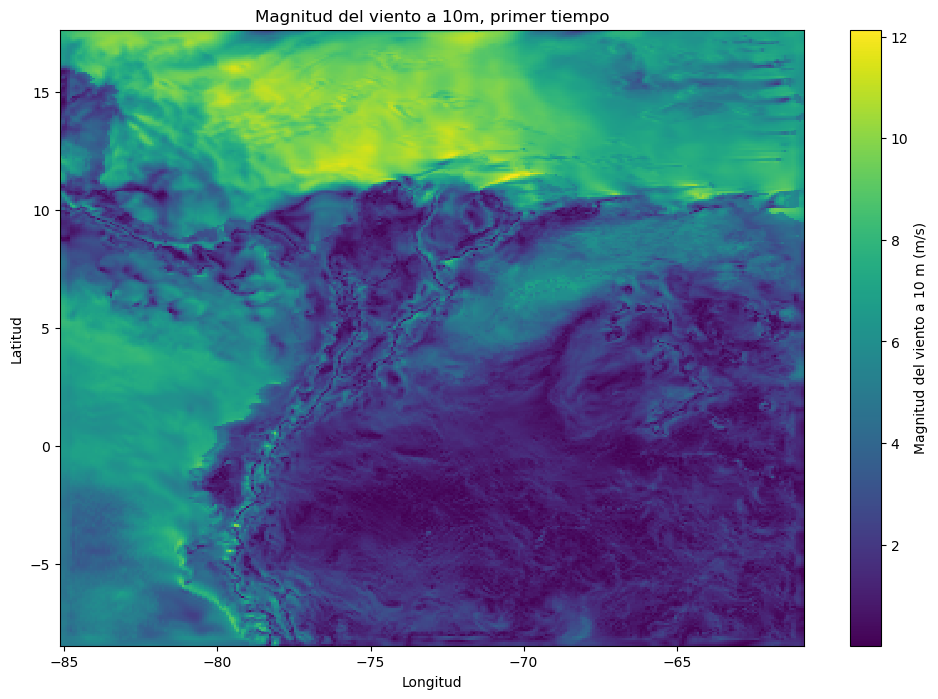

In [26]:
import numpy as np

U10 = ds['U10'].isel(Time=0)
V10 = ds['V10'].isel(Time=0)

vel_viento = np.sqrt(U10.values**2 + V10.values**2)
plt.figure(figsize=(12,8))
pcm = plt.pcolormesh(lons, lats, vel_viento, cmap="viridis")
plt.colorbar(pcm, label="Magnitud del viento a 10 m (m/s)")
plt.title("Magnitud del viento a 10m, primer tiempo")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.show()


## Agregaciones y estadísticas básicas

In [27]:
# Promedio espacial de temperatura a 2m
t2_media_espacial = T2.mean()
print("Temperatura media espacial (primer tiempo):", t2_media_espacial.values, "°C")

# Desviación estándar espacial
t2_std_espacial = T2.std()
print("Desviación estándar espacial (primer tiempo):", t2_std_espacial.values)

# Si hay múltiples tiempos, se puede calcular promedio temporal
# t2_media_temporal = ds['T2'].mean(dim=['Time', 'south_north', 'west_east'])
# print("Temperatura media temporal y espacial:", t2_media_temporal.values)


Temperatura media espacial (primer tiempo): 27.618217 °C
Desviación estándar espacial (primer tiempo): 4.046859


## Recortes espaciales y selección de subdominios geográficos

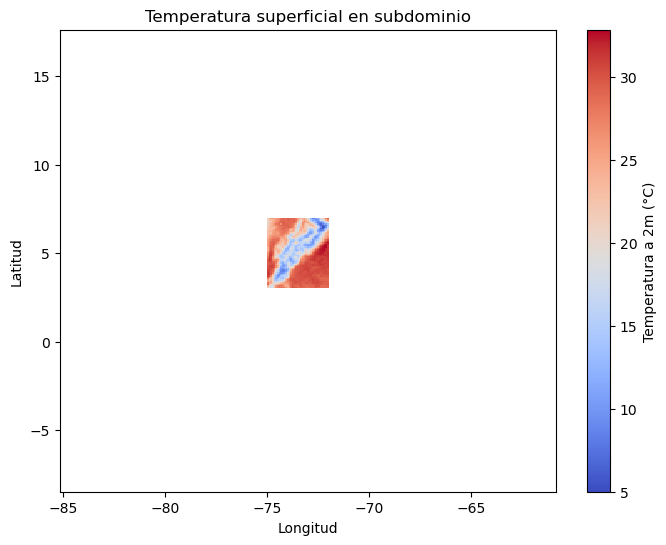

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Definir dominio geográfico
lat_min, lat_max = 3, 7
lon_min, lon_max = -75, -72

# Extraer arrays de lat/lon y temperatura
lats = ds['XLAT'].isel(Time=0)
lons = ds['XLONG'].isel(Time=0)
T2 = ds['T2'].isel(Time=0) - 273.15  # Temperatura en °C

# Crear máscara booleana para recorte espacial
mask = (lats >= lat_min) & (lats <= lat_max) & (lons >= lon_min) & (lons <= lon_max)

# Opcional: enmascarar los valores fuera del dominio deseado como NaN
T2_masked = np.where(mask, T2, np.nan)

plt.figure(figsize=(8,6))
plt.pcolormesh(lons, lats, T2_masked, cmap="coolwarm")
plt.colorbar(label="Temperatura a 2m (°C)")
plt.title("Temperatura superficial en subdominio")
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.show()


## Exportar datos

In [32]:
!pip install openpyxl

  Using cached openpyxl-3.1.5-py2.py3-none-any.whl.metadata (2.5 kB)
  Using cached et_xmlfile-2.0.0-py3-none-any.whl.metadata (2.7 kB)
Using cached openpyxl-3.1.5-py2.py3-none-any.whl (250 kB)
Using cached et_xmlfile-2.0.0-py3-none-any.whl (18 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [openpyxl]━━ 1/2 [openpyxl]


In [33]:
import pandas as pd
import numpy as np

# Supón que quieres la temperatura a 2 m en el primer tiempo
T2 = ds['T2'].isel(Time=0) - 273.15  # [°C]
lons = ds['XLONG'].isel(Time=0)
lats = ds['XLAT'].isel(Time=0)

# Convierte los datos a formato columna (flatten)
T2_flat  = T2.values.flatten()
lons_flat= lons.values.flatten()
lats_flat= lats.values.flatten()

# Construye un DataFrame con columnas de latitud, longitud y temperatura
df = pd.DataFrame({
    'lat': lats_flat,
    'lon': lons_flat,
    'T2_C': T2_flat
})

# Exporta a archivo Excel (.xlsx)
df.to_excel("../data/temperatura_superficie.xlsx", index=False)
print("Temperatura exportada exitosamente a temperatura_superficie.xlsx")


Temperatura exportada exitosamente a temperatura_superficie.xlsx
